# Deep Learning model able to predict the burnt area of the forest

**Objectives:** apply concepts covered in lectures and build a model using Deep Learning with Keras.

**Motivation:**  accurately predicting the burnt forest area is crucial for effectively allocating resources to potential fire locations.



In [1]:
#Import the Necessary Libraries.

# Data Manipulation
import os
import time
import datetime
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Machine Learning - Preprocessing and Transformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models and Metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Deep Learning - TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# TensorFlow Extensions
%tensorflow_version 2.x
%load_ext tensorboard
%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Reading CSV file
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('forestfires.csv')



Saving forestfires.csv to forestfires (5).csv


# A first glance at the data structure.

In [3]:
# Take a look at the first rows.
df.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
# Take a look at the size and type of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
#Check for missing values
df.isnull().any().any()

False

In [6]:
#Check for duplicates
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:")
print(duplicate_rows)

Number of duplicate rows:
4


In [7]:
# Have a look at duplicate rows
duplicates = df[df.duplicated()]
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
53   4  3   aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0   0.00
100  3  4   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0   0.00
215  4  4   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  28.66
303  3  6   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0   0.00


General conclusions on the dataset:

The dataset contains 517 fire locations. The Data Frame has 13 columns. There are 2 columns with categorical data and 11 with numerical features. There are no duplicates or missing values.

# Exploratory Data Analysis
## Numerical Features

In [8]:
#Describe numerical columns
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


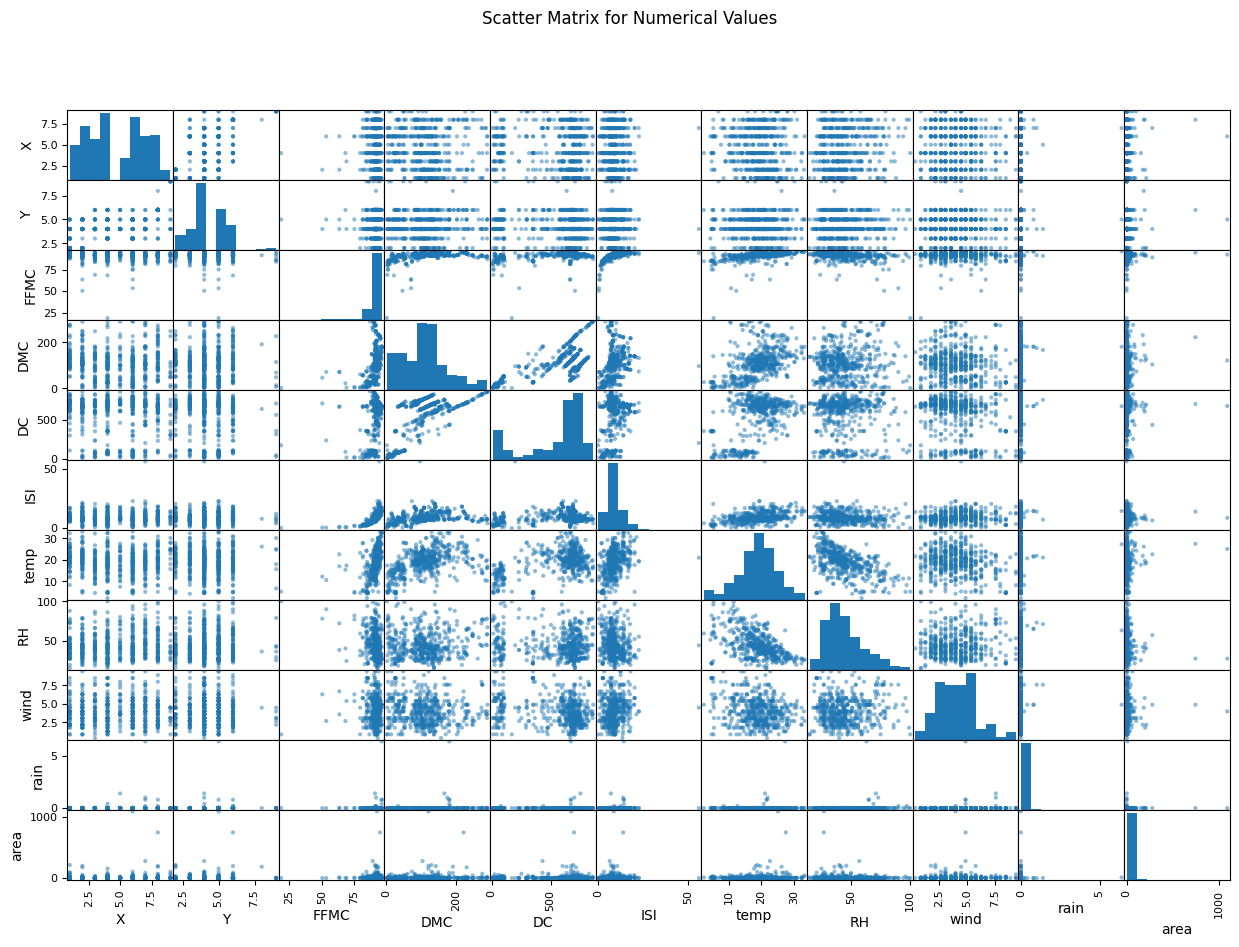

In [9]:
#Build scatter matrix for numerical values.
scatter_matrix(df, figsize=(15, 10))
#Add title
plt.suptitle('Scatter Matrix for Numerical Values')
plt.show()

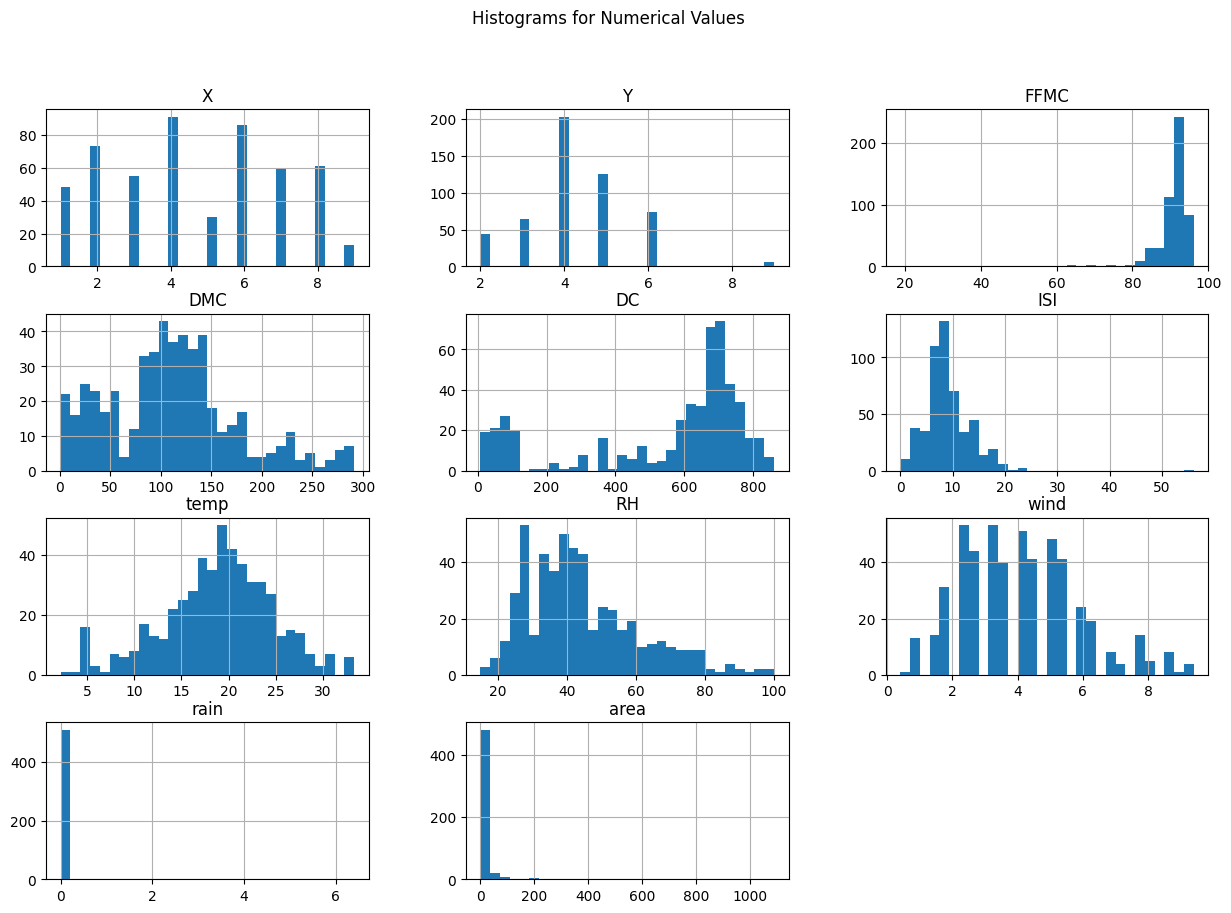

In [10]:
#Build histograms for numerical values.
df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms for Numerical Values')
plt.show()

The distributions of rain, ISI, FFMC, and area are skewed. I will log transform ISI and FFMC and look closer at the rain feature.

In [11]:
#create a function that calculates zero values
def zero(d_f, column):

    # Check how many rows have the area of zero
    zero_count = d_f[d_f[column] == 0].shape[0]

    # Calculate the percentage of rows with zero area
    zero_percentage = (zero_count / d_f.shape[0]) * 100

    # Display the results
    print(f"Number of rows with {column} of zero: {zero_count}")
    print(f"Percentage of rows with {column} of zero: {zero_percentage:.2f}%")

    return zero_count, zero_percentage

# Calculate zero's count and percentage for area
zero_count, zero_percentage = zero(d_f=df, column='area')

Number of rows with area of zero: 247
Percentage of rows with area of zero: 47.78%


In [12]:
# Calculate zero count and percentage for rain
zero_count, zero_percentage = zero(d_f=df, column='rain')

Number of rows with rain of zero: 509
Percentage of rows with rain of zero: 98.45%


The rain feature is extremely skewed. I will code rain as a categorical variable: 0 for no rain and 1 for rain.

Around 48% of burn areas are equal to zero. To better understand the distribution of area feature, I will create two histograms of area:

1) with values less than or equal to 30

2) with values greater than 30.

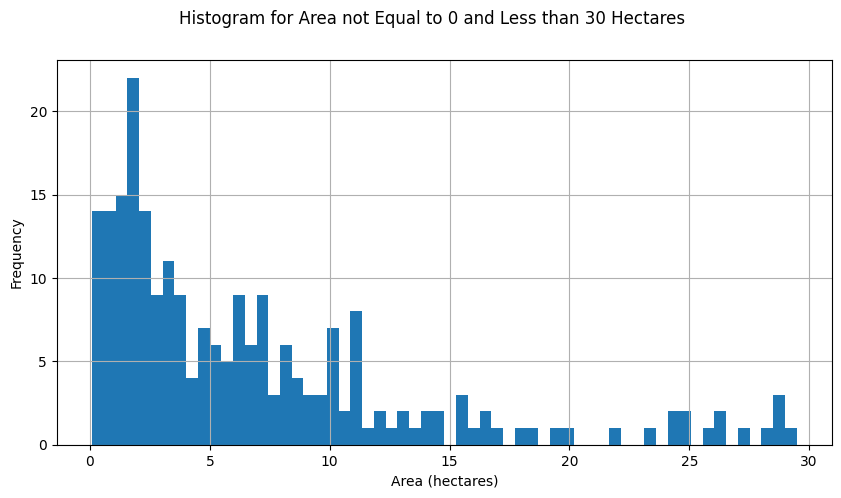

In [13]:
#Histogram with values less than or equal to 30
filtered_df_1 = df[(df['area'] <= 30) & (df['area'] != 0)]
filtered_df_1['area'].hist(bins=60, figsize=(10,5))
plt.suptitle('Histogram for Area not Equal to 0 and Less than 30 Hectares')
plt.xlabel('Area (hectares)')
plt.ylabel('Frequency')
plt.show()

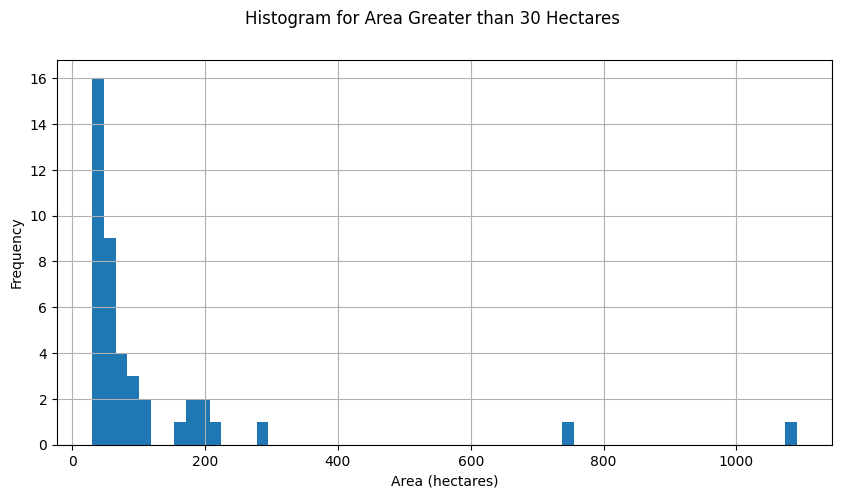

In [14]:
#Histogram with values greater than 30.
filtered_df_2 = df[df['area'] >30]
plt.suptitle('Histogram for Area Greater than 30 Hectares')
filtered_df_2['area'].hist(bins=60, figsize=(10,5))
plt.xlabel('Area (hectares)')
plt.ylabel('Frequency')
plt.show()

Histograms of the area show that most forest fires had an area of less than a hundred hectares. I will log transform the target because its distribution is heavily skewed.

In [15]:
#Print correlation coefficients with popularity score
corr_m = df.corr(numeric_only=True)
corr_pop = corr_m["area"].sort_values()
print (corr_pop)

RH     -0.075519
rain   -0.007366
ISI     0.008258
wind    0.012317
FFMC    0.040122
Y       0.044873
DC      0.049383
X       0.063385
DMC     0.072994
temp    0.097844
area    1.000000
Name: area, dtype: float64


All features are weakly correlated with the area of the burn.

## Categorical features

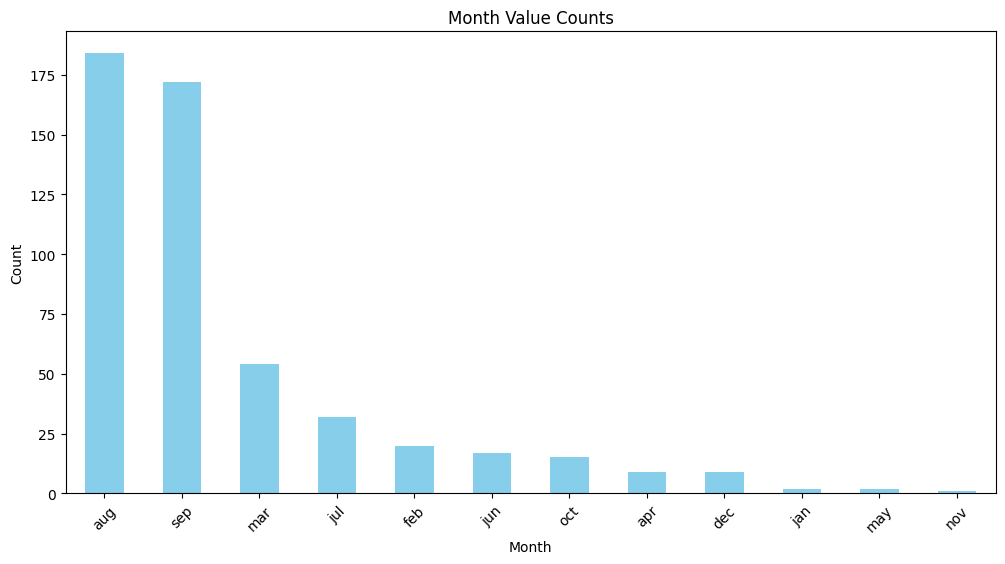

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64


In [16]:
#Create function that outputs counts for each category and produces a bar chart.
def plot_cat_counts(df, cat_column):

    # Calculate counts of each category
    cat_counts = df[cat_column].value_counts().sort_values(ascending=False)

    # Plot a bar chart
    plt.figure(figsize=(12, 6))
    cat_counts.plot(kind='bar', color='skyblue')
    plt.xlabel(cat_column.capitalize())
    plt.ylabel('Count')
    plt.title(f'{cat_column.capitalize()} Value Counts')
    plt.xticks(rotation=45)
    plt.show()

    return cat_counts

# Use the function for month feature
month_counts = plot_cat_counts(df, cat_column='month')
print(month_counts)

This category feature is unbalanced. Most data points were documented in August. January and May are mentioned twice, and November is mentioned only once in the dataset. All months with a count equal to or less than 2 will be excluded from the analysis.


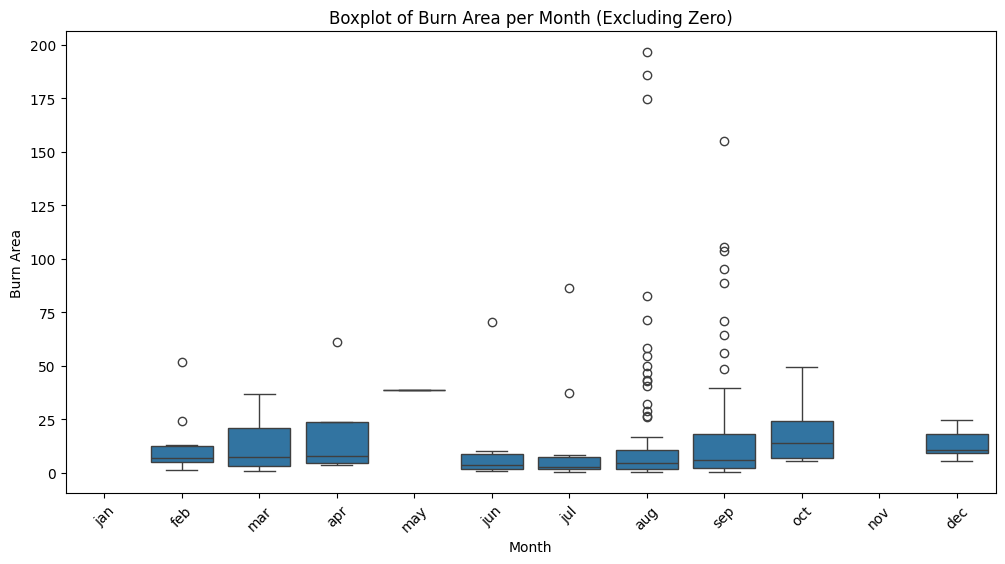

In [17]:
# Exclude rows where 'area' is zero
df_filtered = df[(df['area'] < 200) & (df['area'] != 0)]

# Define the order of months
month_order = [
    'jan', 'feb', 'mar', 'apr', 'may', 'jun',
    'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
]

# Create the boxplot of burn area by a month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='area', data=df_filtered, order=month_order)
plt.xlabel('Month')
plt.ylabel('Burn Area')
plt.title('Boxplot of Burn Area per Month (Excluding Zero)')
plt.xticks(rotation=45)
plt.show()

The medium area of burn is similar across the year. The largest forest fires occur in August and September.

I will remove Jan, May, and Dec from the dataset because the counts are very low.

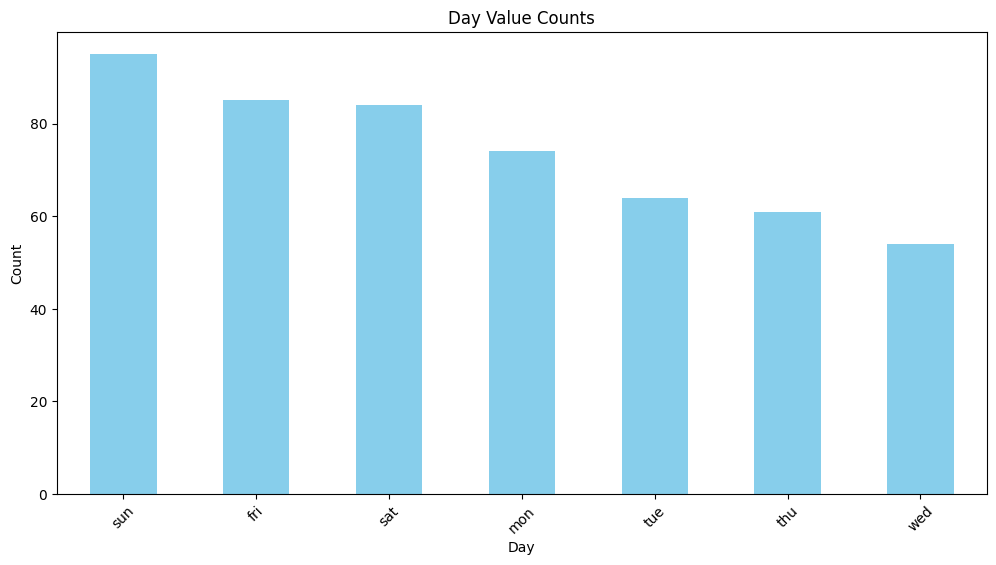

day
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: count, dtype: int64


In [18]:
# Use the plot_cat_counts function for day feature
day_counts = plot_cat_counts(df, cat_column='day')
print(day_counts)

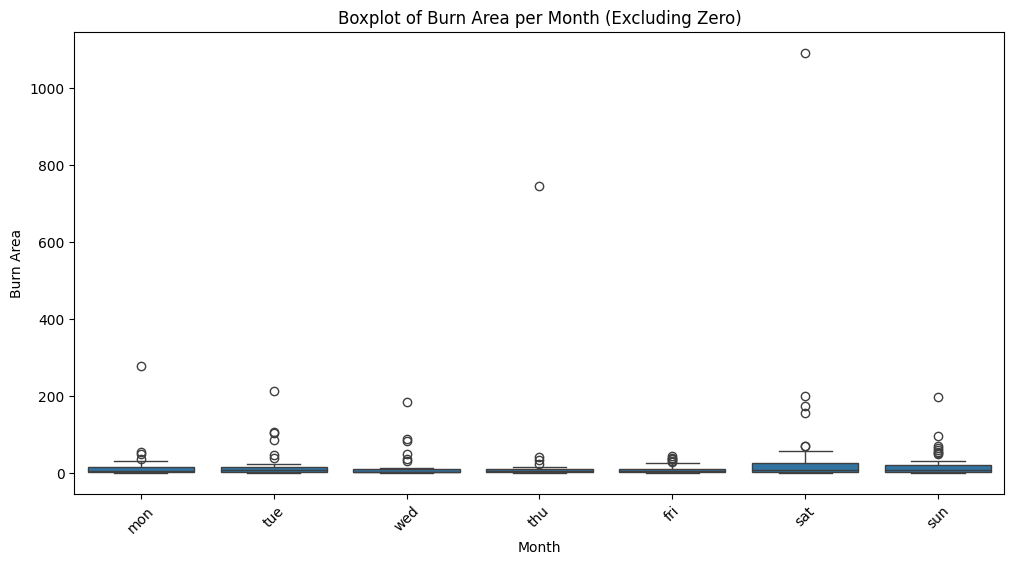

In [19]:
# Exclude rows where 'area' is zero
df_filtered = df[df['area'] != 0]

# Define the order of months
month_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='day', y='area', data=df_filtered, order=month_order)
plt.xlabel('Month')
plt.ylabel('Burn Area')
plt.title('Boxplot of Burn Area per Month (Excluding Zero)')
plt.xticks(rotation=45)
plt.show()

The day feature is more balanced than the month feature. Interestingly, large burn area were not recorded on Fridays.

# Creating a Test Set (Stratified Sampling)
I decided to use the month feature for Stratified Sampling because the months are very unbalanced, and it looks like the size of the burn area changes with the months.

In [20]:
#Remove months with counts 2 and less
month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts > 2].index
df= df[df['month'].isin(valid_months)]

#Create X data
X = df.drop('area', axis=1)
print(X.shape)
#Create Y data
y = df['area']
print(y.shape)


(512, 12)
(512,)


In [21]:
#Create test and training sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=2000, stratify=X['month'])
#Create validation and training sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=2000, stratify=X_train_full['month'])

I created a validation set for convenience. My dataset is very small. Cross-validation might work better for this project.

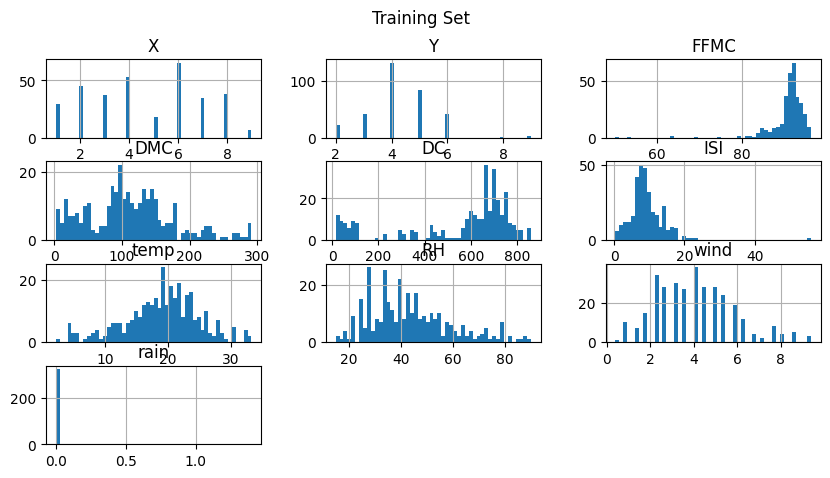

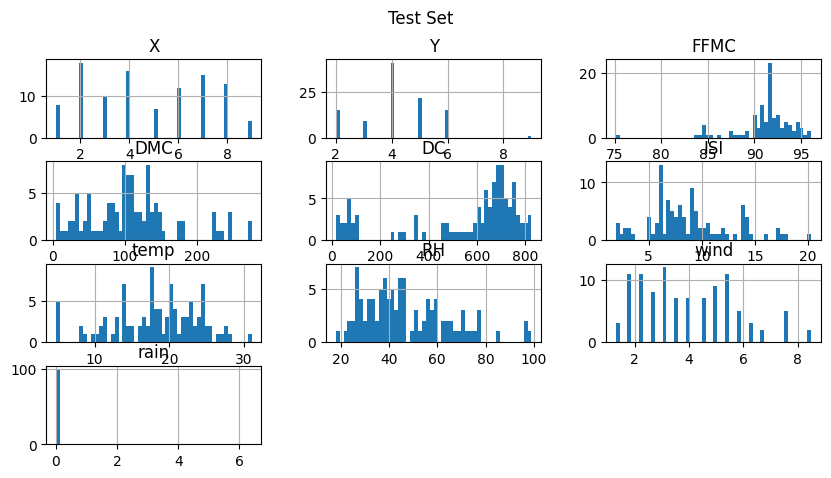

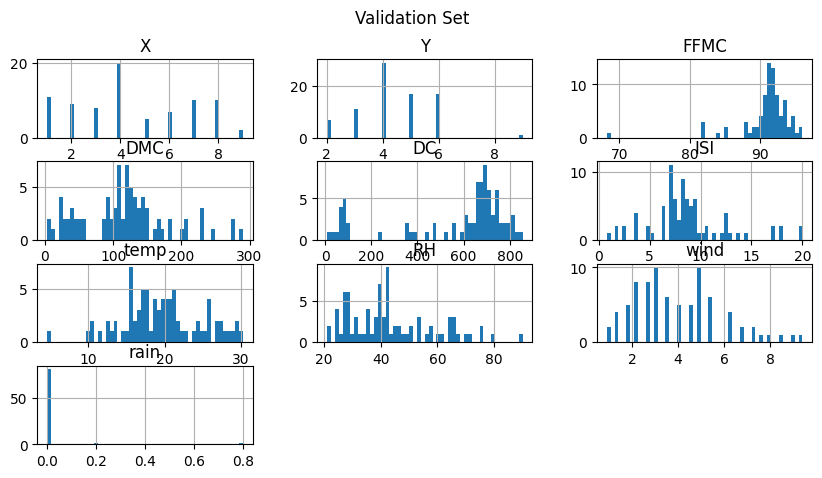

In [22]:
#Compare distributions between test, training, and validation sets

# Plot histograms for training set
X_train.hist(bins=50, figsize=(10, 5))
plt.suptitle('Training Set')
plt.show()

# Plot histograms for test set
X_test.hist(bins=50, figsize=(10, 5))
plt.suptitle('Test Set')
plt.show()

# Plot histograms for validation set
X_valid.hist(bins=50, figsize=(10, 5))
plt.suptitle('Validation Set')
plt.show()

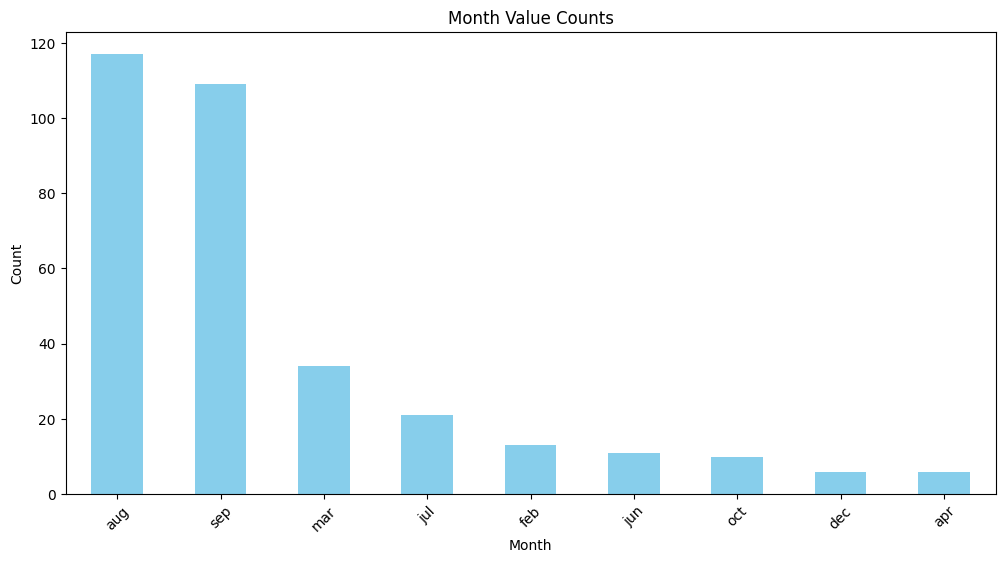

month
aug    117
sep    109
mar     34
jul     21
feb     13
jun     11
oct     10
dec      6
apr      6
Name: count, dtype: int64


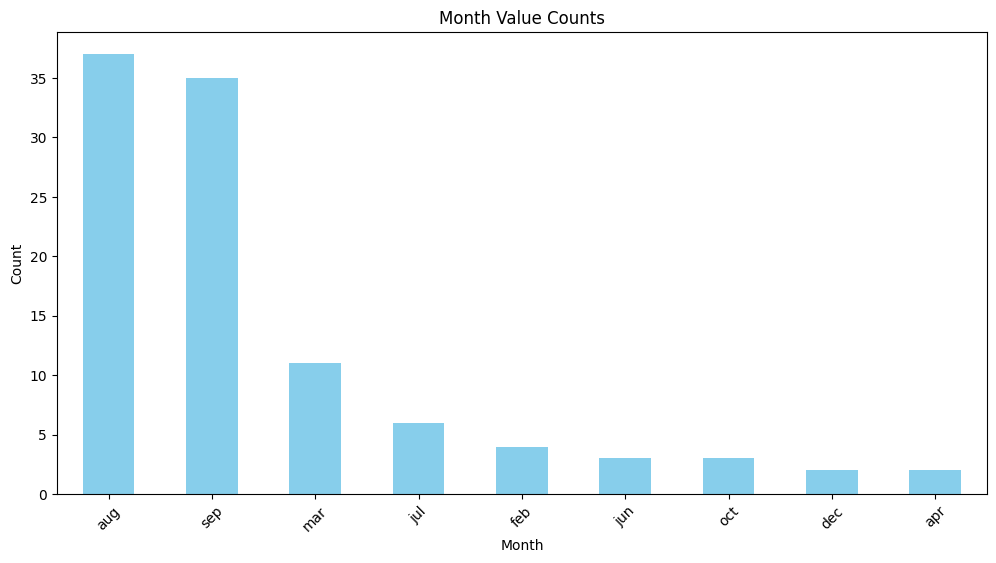

month
aug    37
sep    35
mar    11
jul     6
feb     4
jun     3
oct     3
dec     2
apr     2
Name: count, dtype: int64


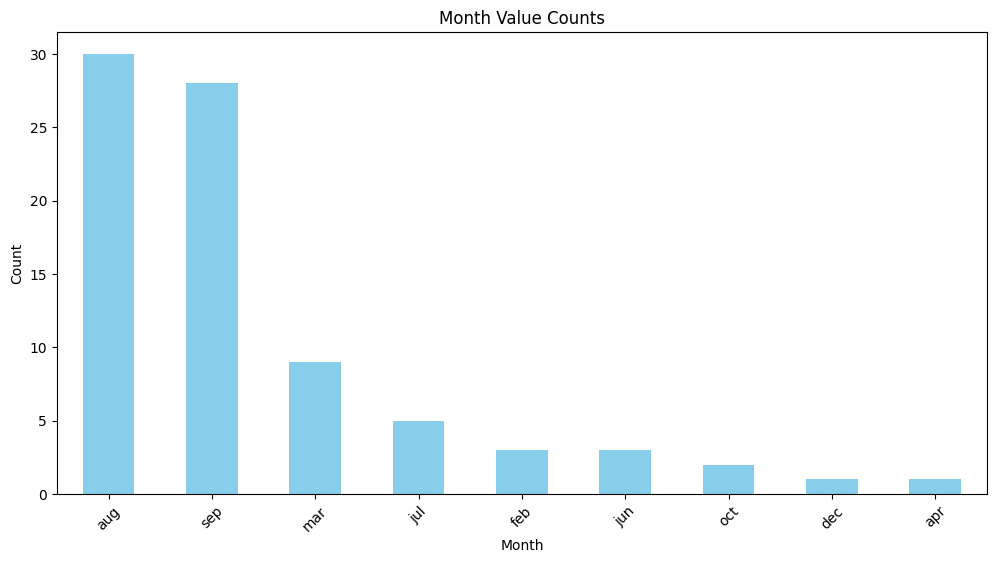

month
aug    30
sep    28
mar     9
jul     5
feb     3
jun     3
oct     2
dec     1
apr     1
Name: count, dtype: int64


In [23]:
# Check distribution of month for training, test, and validation dat sets
month_df_X_train = plot_cat_counts(X_train, cat_column='month')
print(month_df_X_train)

month_X_test = plot_cat_counts(X_test, cat_column='month')
print(month_X_test)

month_X_valid = plot_cat_counts(X_valid, cat_column='month')
print(month_X_valid)

In [24]:
#Create pipeline for log transformed and categorical features

# Define the columns
num_features = ['X', 'Y', 'DMC', 'DC', 'temp', 'RH', 'wind']
cat_features = ['month', 'day']
log_features = ['DC', "ISI", 'FFMC']

# Custom transformer for 'rain' column
rain_transformer = FunctionTransformer(lambda x: (x > 0).astype(int), feature_names_out='one-to-one')

# Create the preprocessing pipelines for both numerical and categorical data

num_pipeline = Pipeline([
     ('impute', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())
    ])

log_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('trans', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocess = ColumnTransformer(
    transformers=[
        ('log', log_pipeline, log_features),
        ('num', num_pipeline, num_features),
        ('rain', rain_transformer, ['rain']),
        ('cat', cat_pipeline, cat_features)
        ])


In [25]:
# Transform the training set
trans_X_train_set = preprocess.fit_transform(X_train)

X_train_transformed_df = pd.DataFrame(trans_X_train_set, columns=preprocess.get_feature_names_out())
X_train_transformed_df.info()

# Transform the validation set
trans_X_valid_set = preprocess.transform(X_valid)

X_valid_transformed_df = pd.DataFrame(trans_X_valid_set, columns=preprocess.get_feature_names_out())


# Transform the test set
trans_X_test_set = preprocess.transform(X_test)

X_test_transformed_df = pd.DataFrame(trans_X_test_set, columns=preprocess.get_feature_names_out())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log__DC         327 non-null    float64
 1   log__ISI        327 non-null    float64
 2   log__FFMC       327 non-null    float64
 3   num__X          327 non-null    float64
 4   num__Y          327 non-null    float64
 5   num__DMC        327 non-null    float64
 6   num__DC         327 non-null    float64
 7   num__temp       327 non-null    float64
 8   num__RH         327 non-null    float64
 9   num__wind       327 non-null    float64
 10  rain__rain      327 non-null    float64
 11  cat__month_aug  327 non-null    float64
 12  cat__month_dec  327 non-null    float64
 13  cat__month_feb  327 non-null    float64
 14  cat__month_jul  327 non-null    float64
 15  cat__month_jun  327 non-null    float64
 16  cat__month_mar  327 non-null    float64
 17  cat__month_oct  327 non-null    flo

In [26]:
# Convert datasets to float32
X_train_transformed_df = X_train_transformed_df.astype('float32')
X_valid_transformed_df = X_valid_transformed_df.astype('float32')
X_test_transformed_df = X_test_transformed_df.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')


# Deep Learning
### Sequential models

I will start with MLPRegressor from Scikit-Learn because it is very convenient. The model uses stochastic gradient descent. MPLRegressor has a ReLU activation function in hidden layers and no activation function for the outer layer. The loss function in the model is a mean squared error. I do not have a lot of training data. To prevent overfitting with ANN, I will start with only two hidden layers and a small number of neurons in each layer.

In [27]:
#Build model with MLPRegressor
mlp_regg = MLPRegressor(hidden_layer_sizes=[15, 15], random_state=2000, max_iter=10000, learning_rate_init=0.0005)
mlp_regg.fit(X_train_transformed_df, y_train)
mpl_pred = mlp_regg.predict(X_valid_transformed_df)
rmse = mean_squared_error(y_valid, mpl_pred, squared=False)
print(rmse)

190.21028


MLPRegresssor has a high RMSE for the validation set of 190.2 and performs poorly.

Even though MLPRegresssor is very convenient, I will use Keras for more flexibility.

Firstly, I would like to add an activation function to the outer layer. I am considering ReLU or softplus to generate positive output (negative values for the fire area do not make sense in the real world).

Secondly, I will apply mean absolute error or Huber loss because my dataset has many outliers.

In addition, I can choose a different optimizer. I will start with Adam.

Finally, I will not change the activation function for hidden layers at this point because ReLU usually performs well.

Epoch 1/40
11/11 [==============================] - 1s 57ms/step - loss: 4452.9175 - root_mean_squared_error: 66.7302 - val_loss: 669.1211 - val_root_mean_squared_error: 25.8674
Epoch 2/40
11/11 [==============================] - 0s 4ms/step - loss: 4441.4458 - root_mean_squared_error: 66.6442 - val_loss: 655.8895 - val_root_mean_squared_error: 25.6103
Epoch 3/40
11/11 [==============================] - 0s 4ms/step - loss: 4423.5264 - root_mean_squared_error: 66.5096 - val_loss: 632.4019 - val_root_mean_squared_error: 25.1476
Epoch 4/40
11/11 [==============================] - 0s 5ms/step - loss: 4394.3711 - root_mean_squared_error: 66.2901 - val_loss: 603.0554 - val_root_mean_squared_error: 24.5572
Epoch 5/40
11/11 [==============================] - 0s 7ms/step - loss: 4350.1802 - root_mean_squared_error: 65.9559 - val_loss: 580.6539 - val_root_mean_squared_error: 24.0968
Epoch 6/40
11/11 [==============================] - 0s 5ms/step - loss: 4323.4087 - root_mean_squared_error: 65.75

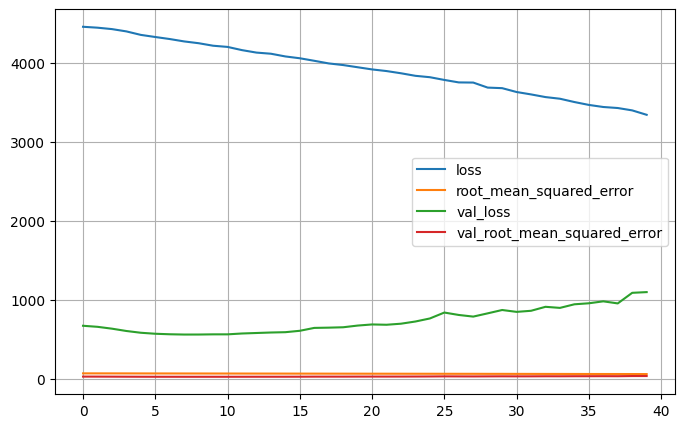

In [28]:
tf.random.set_seed(2000)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(15, activation="relu", input_shape=(X_train_transformed_df.shape[1],)),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(1, activation="softplus")
])
optim = tf.keras.optimizers.Adam(learning_rate=0.006)
model_1.compile(loss="mse", optimizer=optim, metrics=["RootMeanSquaredError"])
history = model_1.fit(X_train_transformed_df, y_train, epochs=40,
                    validation_data=(X_valid_transformed_df, y_valid))

# RMSE values from the training history
val_rmse_history = history.history['val_root_mean_squared_error']

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

The best RMSE on the training set is 57.78. The best RMSE on the validation set is 27.6. It is much better than for MLPRegressor. Unfortunately, it is still very high.

The output shows high Loss and RMSE values that do not improve over epochs. The model does not fit the data well. I think that the model does not overfit because RMSE is similar in training and validation sets.

I will try different model architectures, learning rates, and activation functions. I will increase the number of neurons and hidden layers. I would like to apply practical guidelines from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts" (Chapter 11, p 400). A. Géron recommends using:

1) LeCun initialization (It prevents the vanishing or explosion),

2) SELU activation function (allows model self-normalization and outperforms many activation functions),

3) Nadam optimizer (generally outperforms Adam optimizer),

4) alpha drop out.

In addition, I will apply early stopping to stop the training after no progress is recorded and prevent overfitting.



Epoch 1/60
11/11 [==============================] - 1s 24ms/step - loss: 4453.5889 - root_mean_squared_error: 66.7352 - val_loss: 653.0065 - val_root_mean_squared_error: 25.5540
Epoch 2/60
11/11 [==============================] - 0s 7ms/step - loss: 4420.1562 - root_mean_squared_error: 66.4843 - val_loss: 622.5028 - val_root_mean_squared_error: 24.9500
Epoch 3/60
11/11 [==============================] - 0s 7ms/step - loss: 4416.9868 - root_mean_squared_error: 66.4604 - val_loss: 595.3992 - val_root_mean_squared_error: 24.4008
Epoch 4/60
11/11 [==============================] - 0s 6ms/step - loss: 4353.8984 - root_mean_squared_error: 65.9841 - val_loss: 571.9324 - val_root_mean_squared_error: 23.9151
Epoch 5/60
11/11 [==============================] - 0s 5ms/step - loss: 4309.0889 - root_mean_squared_error: 65.6437 - val_loss: 563.1355 - val_root_mean_squared_error: 23.7305
Epoch 6/60
11/11 [==============================] - 0s 8ms/step - loss: 4295.9424 - root_mean_squared_error: 65.54

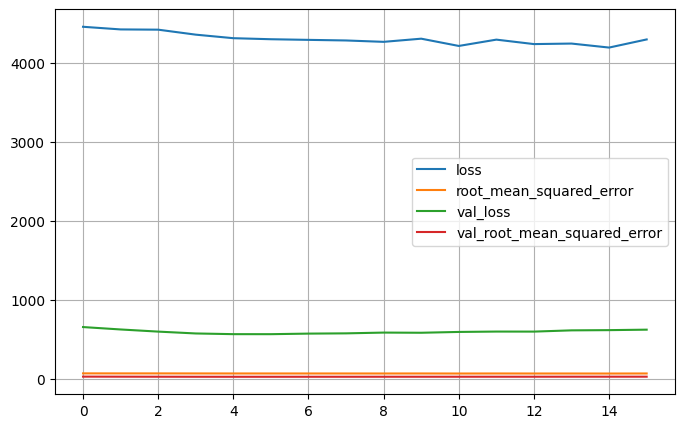

In [29]:
# Setting the random seed for reproducibility
tf.random.set_seed(2000)

# Define the improved model with the specified configurations
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation="selu", kernel_initializer="lecun_normal", input_shape=(X_train_transformed_df.shape[1],)),
    tf.keras.layers.AlphaDropout(0.25),
    tf.keras.layers.Dense(15, activation="selu", kernel_initializer="lecun_normal"),
        tf.keras.layers.Dense(1)
])

# Compile the model with Nadam optimizer
optim = tf.keras.optimizers.Nadam(learning_rate=0.006)
model_2.compile(loss="mse", optimizer=optim, metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Early stopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model_2.fit(X_train_transformed_df, y_train, epochs=60,
                      validation_data=(X_valid_transformed_df, y_valid),
                      callbacks=[early_stopping])

#mse_test, rmse_test = model.evaluate(X_test_transformed_df, y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

This model performs better on the validation set than the previous model. The highest RMSE on the training set is 64.73. The highest RMSE on validation set 23.73

### Wide and Deep neural network

The sequential model makes all data go through all layers, which might hinder learning from simple rules. I will build a Wide and Deep neural network, which allows learning both deep and simple patterns.

In [30]:
hidden_l1 = tf.keras.layers.Dense(10, activation="relu")
hidden_l2 = tf.keras.layers.Dense(10, activation="relu")
concat_l = tf.keras.layers.Concatenate()
output_l = tf.keras.layers.Dense(1, activation="softplus")

input_ = tf.keras.layers.Input(shape=X_train_transformed_df.shape[1:])
hidden_1 = hidden_l1(input_)
hidden_2 = hidden_l2(hidden_1)
concat = concat_l([input_, hidden_2])
output = output_l(concat)

model_3 = tf.keras.Model(inputs=[input_], outputs=[output])

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 10)                   260       ['input_1[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 10)                   110       ['dense_6[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 35)                   0         ['input_1[0][0]',             
                                                                     'dense_7[0][0]']         

Epoch 1/30
11/11 [==============================] - 1s 28ms/step - loss: 4454.4463 - root_mean_squared_error: 66.7416 - val_loss: 675.5253 - val_root_mean_squared_error: 25.9909
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 4453.3267 - root_mean_squared_error: 66.7333 - val_loss: 674.7842 - val_root_mean_squared_error: 25.9766
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 4452.4604 - root_mean_squared_error: 66.7268 - val_loss: 674.0045 - val_root_mean_squared_error: 25.9616
Epoch 4/30
11/11 [==============================] - 0s 7ms/step - loss: 4451.4214 - root_mean_squared_error: 66.7190 - val_loss: 673.1671 - val_root_mean_squared_error: 25.9455
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 4450.1011 - root_mean_squared_error: 66.7091 - val_loss: 672.2753 - val_root_mean_squared_error: 25.9283
Epoch 6/30
11/11 [==============================] - 0s 8ms/step - loss: 4449.0708 - root_mean_squared_error: 66.70

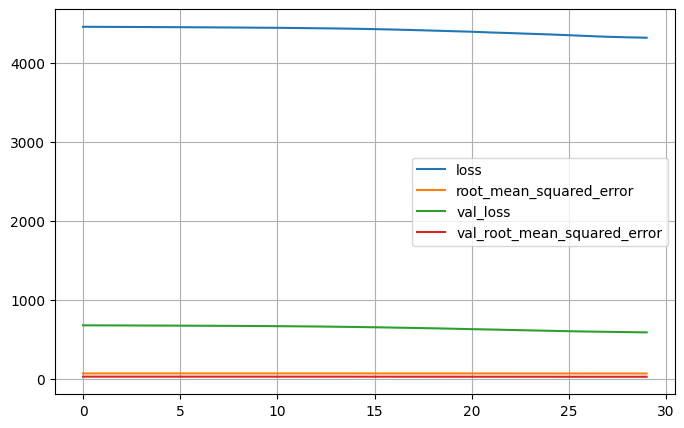

In [31]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0009)
model_3.compile(loss="mse", optimizer=optim, metrics=["RootMeanSquaredError"])

history = model_3.fit(X_train_transformed_df, y_train, epochs=30, validation_data=(X_valid_transformed_df, y_valid))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

Wide and Deep neural networks perform worst on the validation set compared to sequential models. The RMSE for the training set is 65.7. The best RMSE for the validation set is 24.21.

Model #2 performed the best and I will evaluate it on test set.

In [32]:
#Evaluate the model to the test set
mse_test, rmse_test = model_2.evaluate(X_test_transformed_df, y_test)
print(f"Root Mean Squared Error (RMSE) on the test set: {rmse_test}")

4/4 [==============================] - 0s 3ms/step - loss: 6008.3442 - root_mean_squared_error: 77.5135
Root Mean Squared Error (RMSE) on the test set: 77.51351165771484


The model's RMSE on the test set is 77.51. This is very high, especially considering that most burn areas are less than 100. I think that all models performed poorly because I do not have enough training data. I think that shallow models might perform better on such a small data set.

1/1 [==============================] - 0s 145ms/step
Predicted values:
[[10.552507  ]
 [13.733773  ]
 [14.7545805 ]
 [ 5.313219  ]
 [ 9.694359  ]
 [11.869481  ]
 [ 0.03904195]
 [ 8.880558  ]
 [18.289373  ]
 [17.827457  ]
 [16.876083  ]
 [10.2331705 ]
 [10.93043   ]
 [ 9.99973   ]
 [ 9.555625  ]
 [16.953205  ]
 [10.308663  ]
 [15.279742  ]
 [13.112611  ]
 [19.367247  ]
 [16.425371  ]
 [ 6.7725873 ]
 [ 0.9495258 ]
 [12.359776  ]
 [ 6.8651495 ]
 [11.799702  ]
 [19.423992  ]
 [12.667795  ]
 [12.341997  ]
 [22.558764  ]]
Actual values:
[ 0.    0.    6.58 26.    0.    0.    2.14  0.    0.    1.95  0.   24.77
  0.   70.32 46.7   9.27  0.    0.77  0.    0.    0.    8.98  0.    1.46
  0.   29.48  7.48  0.   24.23  0.  ]


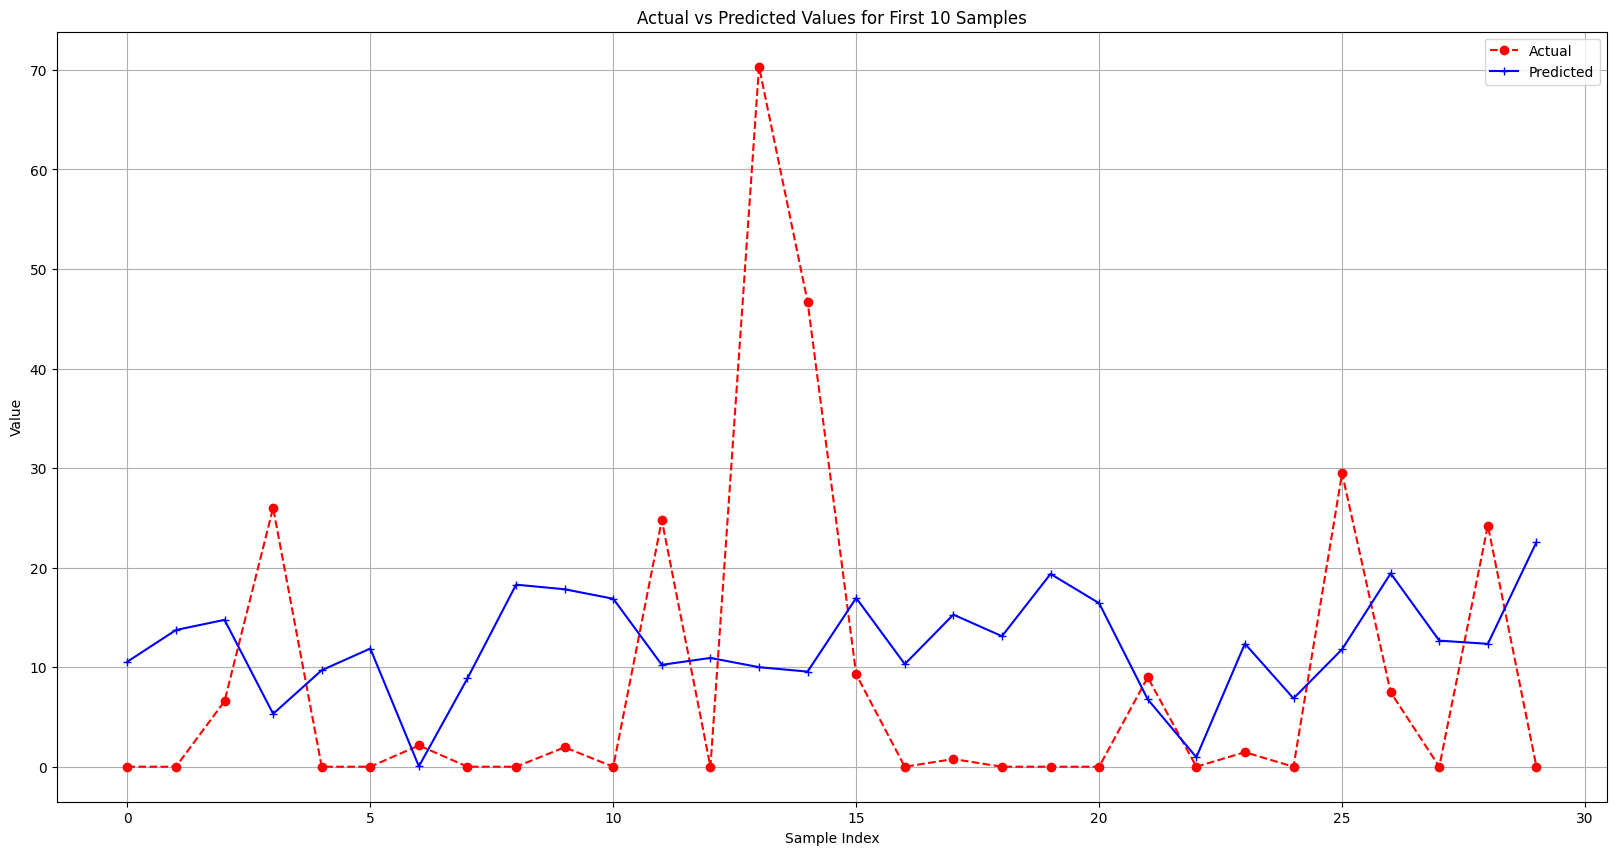

In [34]:
# Predict on the first 30 samples from X_test_transformed
model_2_pred = model_2.predict(X_test_transformed_df[:30])

# Print predicted values and actual values for the first 10 samples
print("Predicted values:")
print(model_2_pred)
print("Actual values:")
print(y_test[:30].values)

# EMake arrays the same shape
model_2_pred_flat = model_2_pred.flatten()

# Plot the actual vs predicted values
plt.figure(figsize=(20, 10))
plt.plot(y_test[:30].values, 'ro--', label='Actual')
plt.plot(model_2_pred_flat, 'b+-', label='Predicted')
plt.title('Actual vs Predicted Values for First 10 Samples')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

As mentioned above, this model performs poorly. Most predicted values are very different from the actual burn area. There are a few approaches I could apply to improve my model's performance:

1) work more on cleaning that and feature engineering,

2) tune models parameters,

3) use cross-validation.

## References
1) El Gemayel, J. (2024) “CS830: Machine Learning for Data Analytics” University of Strathclyde, Glasgow

2) Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.). O'Reilly Media.